# Working on self-drive car sentiments

Train and Evaluate model with two classes i.e Risk and Benefit

We shall remove Neutral samples

# 1)- Importing Key Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hassansherwani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# For evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# 2)- Loading Data

In [5]:
import pickle
#Loading from firm cleaned file
df = pd.read_pickle('model.pkl')
df.shape

(15000, 2)

In [6]:
df.head()

,TEXT,Sent_type
443783,Unless you’re trying to buy me a Mercedes G-wa...,Neutral
229375,Ford recently made news by suspending producti...,Risky
20760,Just to get a closer look at the interior of o...,Neutral
337983,"In October 2014, General Motors got permission...",Risky
247040,I took a spin in a self-driving car today. My ...,Benefit


### 2.a)-Value counts for classes

In [7]:
df.Sent_type.value_counts()

Neutral    6468
Benefit    6089
Risky      2443
Name: Sent_type, dtype: int64

In [8]:
df.Sent_type.value_counts(normalize=True)

Neutral    0.431200
Benefit    0.405933
Risky      0.162867
Name: Sent_type, dtype: float64

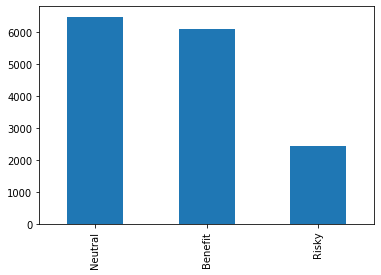

In [9]:
df.Sent_type.value_counts().plot(kind='bar')

### 2.b. Using only Benefit and Risk related sentiments

In [10]:
df=df[df.Sent_type != "Neutral"]

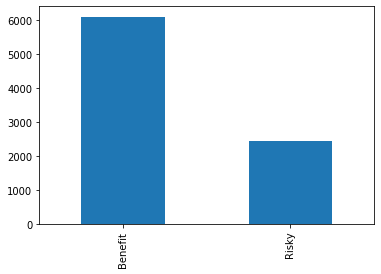

In [11]:
df.Sent_type.value_counts().plot(kind='bar')

In [12]:
df.shape

(8532, 2)

In [13]:
df.Sent_type.value_counts()

Benefit    6089
Risky      2443
Name: Sent_type, dtype: int64

In [14]:
df.Sent_type.value_counts(normalize=True)

Benefit    0.713666
Risky      0.286334
Name: Sent_type, dtype: float64

### 2.c.Label the categorical values

- Benefit=1
- Risk=0

In [15]:
df['labels'] = df.Sent_type.map({'Risky':0, 'Benefit':1})

In [16]:
df.head()

,TEXT,Sent_type,labels
229375,Ford recently made news by suspending producti...,Risky,0
337983,"In October 2014, General Motors got permission...",Risky,0
247040,I took a spin in a self-driving car today. My ...,Benefit,1
180871,Autonomous vehicles to take self-driving trips...,Benefit,1
140233,Uber Strikes Deal With Volvo to Bring Self-Dri...,Risky,0


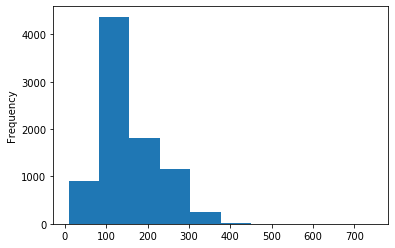

In [17]:
df['TEXT'].str.len().plot.hist()

# 3)-Cleaning

In [18]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['rt', 'http','https','pictwittercom']) # extend stopwords; rt means re-tweet
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [19]:
df['cleaned']=[text_prepare(x) for x in df['TEXT']]

In [20]:
print(df.TEXT[:5])

229375    Ford recently made news by suspending producti...
337983    In October 2014, General Motors got permission...
247040    I took a spin in a self-driving car today. My ...
180871    Autonomous vehicles to take self-driving trips...
140233    Uber Strikes Deal With Volvo to Bring Self-Dri...
Name: TEXT, dtype: object


In [21]:
df.cleaned[:5]

229375    ford recently made news suspending production ...
337983    october 2014 general motors got permission fli...
247040    took spin selfdriving car today safety driver ...
180871    autonomous vehicles take selfdriving trips acr...
140233    uber strikes deal volvo bring selfdriving cars...
Name: cleaned, dtype: object

### most common words

In [22]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from collections import Counter
words_counts = Counter([word for line in df['cleaned'] for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Top 10
most_common_words[:10]

[('selfdriving', 1384),
 ('bmw', 1321),
 ('porsche', 1185),
 ('cars', 1148),
 ('car', 988),
 ('mercedes', 977),
 ('motors', 952),
 ('audi', 843),
 ('new', 688),
 ('general', 681)]

# 4)- LSTM

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

In [24]:
df.head()

,TEXT,Sent_type,labels,cleaned
229375,Ford recently made news by suspending producti...,Risky,0,ford recently made news suspending production ...
337983,"In October 2014, General Motors got permission...",Risky,0,october 2014 general motors got permission fli...
247040,I took a spin in a self-driving car today. My ...,Benefit,1,took spin selfdriving car today safety driver ...
180871,Autonomous vehicles to take self-driving trips...,Benefit,1,autonomous vehicles take selfdriving trips acr...
140233,Uber Strikes Deal With Volvo to Bring Self-Dri...,Risky,0,uber strikes deal volvo bring selfdriving cars...


### 4.1)- Pre-modeling steps

In [25]:
y=df['Sent_type']
X=df.cleaned

In [26]:
print(X.shape)
print(y.shape)

(8532,)
(8532,)


In [27]:
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split(y, random_state=42)

In [28]:
print(y_train.shape)
print(y_test.shape)

(6399,)
(2133,)


In [29]:
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

y_train_ohe=one_hot_encode_object_array(y_train)
y_test_ohe=one_hot_encode_object_array(y_test)

In [30]:
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(6399, 2)
(2133, 2)


In [31]:
df['cleaned'].shape

(8532,)

In [32]:
X=[text_prepare(x) for x in df['cleaned']]

In [33]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

In [34]:
X.shape

(8532, 36)

In [35]:
X_train, X_test = train_test_split(X, random_state=2019)

In [36]:
X_train.shape, X_test.shape

((6399, 36), (2133, 36))

### 4.2)-Build mode

In [37]:

embed_dim = 128
lstm_out = 196
max_fatures = 2000

In [38]:
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
# X.shape[1] refers to number of columns 
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 36, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 36, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


### 4.3)-Train model

In [39]:
batch_size = 32
epochs = 20

In [40]:
from keras.callbacks import EarlyStopping

In [41]:
history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 5759 samples, validate on 640 samples
Epoch 1/20
5759/5759 [==============================] - 24s 4ms/step - loss: 0.6045 - accuracy: 0.7128 - val_loss: 0.6054 - val_accuracy: 0.7094
Epoch 2/20
5759/5759 [==============================] - 23s 4ms/step - loss: 0.5734 - accuracy: 0.7157 - val_loss: 0.6380 - val_accuracy: 0.6938
Epoch 3/20
5759/5759 [==============================] - 24s 4ms/step - loss: 0.5086 - accuracy: 0.7513 - val_loss: 0.7044 - val_accuracy: 0.6578
Epoch 4/20
5759/5759 [==============================] - 24s 4ms/step - loss: 0.4487 - accuracy: 0.7897 - val_loss: 0.7843 - val_accuracy: 0.6406


In [ ]:
accr = model.evaluate(X_test,y_test_ohe)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

# 5)-Model Evaluation

In [42]:
# predict probabilities for test set
y_pred = model.predict(X_test)

In [43]:
y_pred[:5]

array([[0.9422246 , 0.05777532],
       [0.5173078 , 0.4826922 ],
       [0.83429915, 0.16570084],
       [0.91974694, 0.08025308],
       [0.9612037 , 0.03879632]], dtype=float32)

**This is probabilities of our output. We need to convert to crisp classes.**

In [44]:
# predict crisp classes for test set. Output will be 1-D
yhat_classes = model.predict_classes(X_test, verbose=0)

In [45]:
yhat_classes[:5]

array([0, 0, 0, 0, 0])

In [46]:
y_test_ohe[:5]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [47]:
#Other way to do it
y_test_class = np.argmax(y_test_ohe,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [48]:
y_test_class[:5]

array([0, 0, 1, 0, 1])

In [49]:
y_pred_class[:5]

array([0, 0, 0, 0, 0])

## Classification Report

In [50]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.71      0.87      0.78      1523
           1       0.24      0.10      0.14       610

    accuracy                           0.65      2133
   macro avg       0.47      0.48      0.46      2133
weighted avg       0.57      0.65      0.60      2133



## Confusion Matrix

In [51]:
print(confusion_matrix(y_test_class,y_pred_class))

[[1325  198]
 [ 549   61]]


<Figure size 864x864 with 0 Axes>

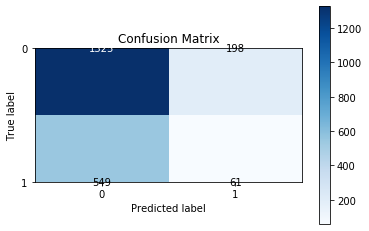

In [52]:
import scikitplot as skplt
plt.figure(figsize=(12,12))
skplt.metrics.plot_confusion_matrix(y_test_class,y_pred_class)
plt.show()

## Accuracy and loss function

In [53]:
# for training set
loss, accuracy = model.evaluate(X_train, y_train_ohe, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))

Training Accuracy: 0.8186
Training Loss: 0.4115


In [54]:
# For test set
loss, accuracy = model.evaluate(X_test, y_test_ohe, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Testing Accuracy:  0.6498
Testing Loss:  0.7581


In [55]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

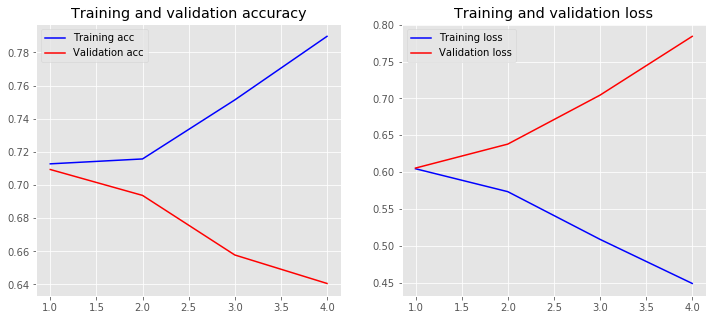

In [56]:
plot_history(history)

In [57]:
#[print(df['text'][i], y_pred[i], y_test_ohe[i]) for i in range(0, 5)]

# Using 1-D LSTM

In [58]:
y=df['labels']

### a)-Accuracy

(tp + tn) / (p + n)

In [59]:
y=df['labels']

In [60]:
y_train, y_test = train_test_split(y, random_state=2019)

In [61]:
y_test[:5]

420505    0
43896     0
218362    1
135637    1
3080      1
Name: labels, dtype: int64

In [62]:
yhat_classes[:5]

array([0, 0, 0, 0, 0])

In [63]:
y_test_class[:5]

array([0, 0, 1, 0, 1])

In [64]:
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)

Accuracy: 0.323957


This one is more like null accuracy

### Precision: 

tp / (tp + fp)

In [65]:
precision = precision_score(y_test, yhat_classes)

In [66]:
precision

0.7065637065637066

### recall: 

tp / (tp + fn)

In [67]:
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)

Recall: 0.118141


### f1:

2 tp / (2 tp + fp + fn)

In [68]:
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

F1 score: 0.202434


### kappa

In [69]:
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)

Cohens kappa: -0.007107
